In [71]:
# Import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
from datetime import datetime as dt
from datetime import timedelta 

# Reflect Tables into SQLAlchemy ORM

In [88]:
# Import Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import cast, Date

In [89]:
# create engine to hawaii.sqlite

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [75]:
# reflect an existing database into a new model

Base = automap_base()
Base.prepare(engine, reflect=True)

In [90]:
# View all of the classes that automap found

inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [77]:
# Save references to each table

Measurements = Base.classes.measurement
Stations = Base.classes.station

In [91]:
# View columns in Measurements

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [92]:
# View columns in Stations

columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [93]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Precipitation Analysis

In [110]:
# Find the most recent date in the data set.

    # Sort measurements by descending by date and return the first one (the most recent date) 
most_recent_date = session.query(Measurements).\
    order_by(Measurements.date.desc()).first()

print(f"Most recent date in the data set is {most_recent_date.date}")


Most recent date in the data set is 2017-08-23


In [112]:
# Design a query to retrieve the last 12 months of precipitation data

    # Turn the most recent date into a datetime object so that the date of 1 year earlier can be calculated
most_recent_date_dt_object = dt.strptime(most_recent_date.date, '%Y-%m-%d')   

    # Calculate date of 12 months before
year_ago = dt.date(most_recent_date_dt_object) - timedelta(days=365)

    # Query date and precipiation, filter for last 12 months group and order by date
stmt = session.query(Measurements.date, func.avg(Measurements.prcp)).\
    filter(Measurements.date > year_ago).\
    group_by(Measurements.date).order_by(Measurements.date).statement
 
    # Create the dataframe and clean up column names
average_prcp_df = pd.read_sql_query(stmt, session.bind).\
    rename(columns={'date' : 'Date', 'avg_1': 'Ave Precip in Inches'})        

average_prcp_df.head()

,Date,Ave Precip in Inches
0,2016-08-24,1.555000
1,2016-08-25,0.077143
2,2016-08-26,0.016667
3,2016-08-27,0.064000
4,2016-08-28,0.516667


In [113]:
# Use Pandas to calcualte the summary statistics for the precipitation data

average_prcp_df.describe()      

,Ave Precip in Inches
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


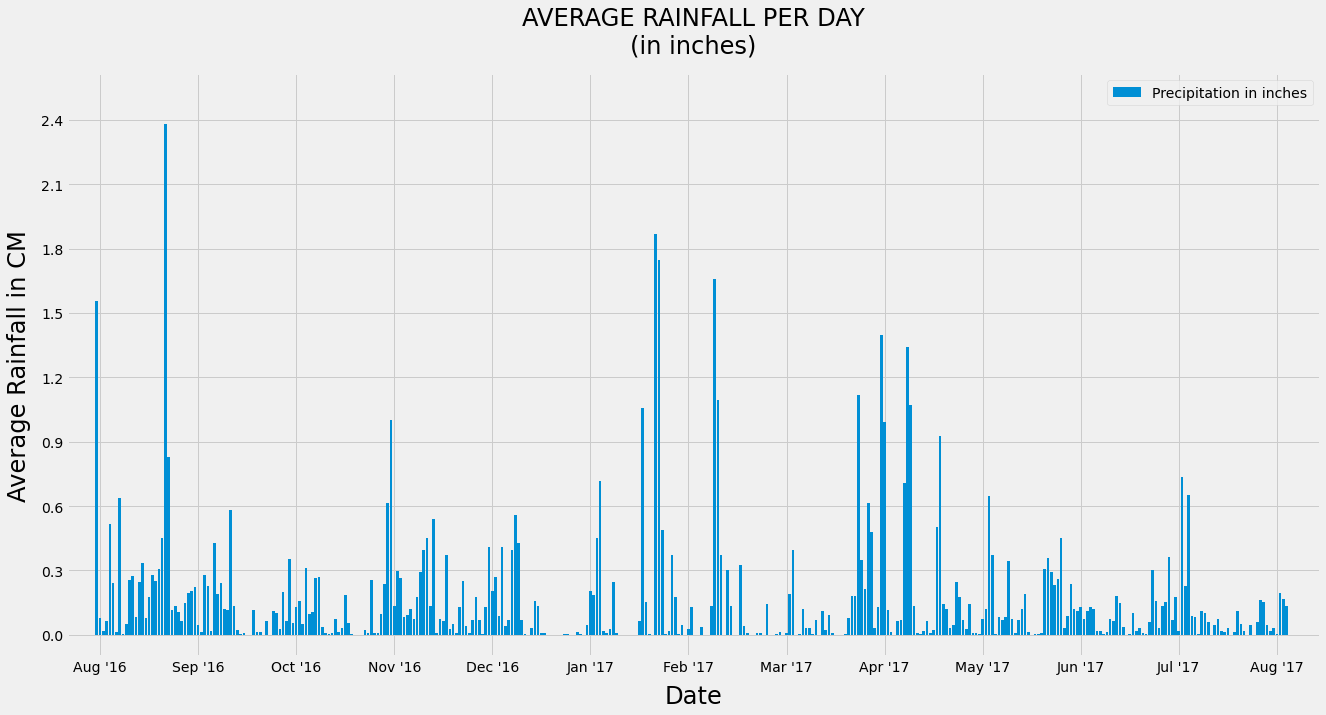

In [114]:
#Plot the average precipitation results. 

plt.figure(num=None, figsize=(20,10), dpi=None,                  # Set up plt figure
            facecolor=None, edgecolor=None, frameon=True)

x_axis = average_prcp_df['Date']                                 # Set x axis as dates

y_axis = average_prcp_df['Ave Precip in Inches']

l = len(average_prcp_df)                                         # This next blocks sets up the ticks
prcp_range = max(y_axis)-min(y_axis)
x_tx = [tk_x for tk_x in range(1, (l)+1, int(l/12))]             # Calculates number of x ticks as
                                                                 #    as number of months in the data set
y_tx = [round(tk_y,2) for tk_y in np.arange(0,                   # Calculates number of y ticks to give them a nice
        math.ceil(prcp_range), math.ceil(prcp_range)/10)]        #    spread
                   
                                                                 # Automatically calculates and formats the months
labels=[dt.strptime(x_axis[tk], '%Y-%m-%d').strftime("%b \'%y") for tk in x_tx]  # in the data set to use as x ticks
                              
plt.xticks(ticks=x_tx, labels=labels)                            # Assign x ticks
plt.yticks(ticks=y_tx)                                           # Assign y ticks

plt.bar(x_axis, y_axis, label='Precipitation in inches')         # Plot the bar chart

plt.xlim(-len(x_axis)*.025, len(x_axis)*1.025)                   # Give x axis some space
plt.ylim(-.1, max(y_axis)*1.1)                                   # Give y axis some space

plt.title("AVERAGE RAINFALL PER DAY\n(in inches)",               # Set up title
          fontsize='xx-large', loc='center', pad=20)
          
plt.xlabel("Date", fontsize='xx-large', labelpad=10)             # Set up x axis label
plt.ylabel("Average Rainfall in CM",                             # Set up y axis label
           fontsize='xx-large', labelpad=10)
plt.legend()                                                     # Add legend


plt.savefig("output_charts/average_rainfall.png",                # Export chart
            transparent=False)
plt.show()

# Exploratory Station Analysis

In [115]:
# Design a query to calculate the total number stations in the dataset

stations_count = session.query(Stations.station.distinct()).count()
print(f"Total number of weather stations in the dataset: {stations_count}")

Total number of weather stations in the dataset: 9


In [117]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

    # 1. Query station id, station name and count of measurements, 
    # 2. Filter by station name (JOIN),
    # 3. Group by station,
    # 4. And order in descending
    
stmt = session.query(Stations.id, Measurements.station, func.count(Measurements.station)).\
    filter(Measurements.station == Stations.station).\
    group_by(Measurements.station).\
    order_by(func.count(Measurements.station).desc()).statement

    # Create the dataframe and clean up column names
most_active_stations = pd.read_sql_query(stmt, session.bind).\
    rename(columns={'station' : 'Station Name',
                    'id' : 'Station ID', 
                    'count_1': '# of Measurements'})

most_active_stations

,Station ID,Station Name,# of Measurements
0,7,USC00519281,2772
1,1,USC00519397,2724
2,2,USC00513117,2709
3,6,USC00519523,2669
4,9,USC00516128,2612
5,3,USC00514830,2202
6,8,USC00511918,1979
7,4,USC00517948,1372
8,5,USC00518838,511


In [118]:
# Using the most active station id from the previous query, calculate the 
#lowest, highest, and average temperature.

    # Determine most active station:
    #    1. Query stations ids and stations names
    #    2. Filter by station name (JOIN)
    #    3. Group y station name
    #    4. Order by number of measurements in descendeing
    #    5. Return the first row, meaning the most active station
most_active_station = session.query(Stations.id, Stations.station).\
    filter(Measurements.station == Stations.station).\
    group_by(Measurements.station).order_by(func.count(Measurements.station).desc()).first()

    # Get the lowest, highest, and average temperature for the most active station:
    #    1. Query min, max and avg temp using func.min, func.max, and func.avg and assign directly to variables
    #    2. Filter by station name (JOIN)
    #    3. Filter by id of most active station determined in the previous query
    min_temp, max_temp, avg_temp  = session.query(func.min(Measurements.tobs), 
                                 func.max(Measurements.tobs), 
                                 func.round(func.avg(Measurements.tobs), 1)).\
                    filter(Measurements.station == Stations.station).\
                    filter(Stations.id == most_active_station.id).all()[0]


    # Create the dataframe and clean up column names
min_max_avg_tobs_df = pd.DataFrame({'Most Active Station ID' : [most_active_station.id], 
                                    'Most Active Station Name' : [most_active_station.station],
                                    'Min Temp': min_temp,
                                    'Max Temp' : max_temp,
                                    'Avg Temp' : avg_temp})

min_max_avg_tobs_df


,Most Active Station ID,Most Active Station Name,Min Temp,Max Temp,Avg Temp
0,7,USC00519281,54.0,85.0,71.7


In [124]:
# Using the most active station id Query the last 12 months of temperature observation 
# data for this station and plot the results as a histogram


    # NOTE TO GRADED: I repeat this 'most_active_station' block so that I could copy and paste this whole
    #  section into Flask later on. I know it's repetitive, but it was easier to have all the code together. 
    
    # Determine most active station:
    #   1. Query stations ids and stations names
    #   2. Filter by station name (JOIN)
    #   3. Group y station name
    #   4. Order by number of measurements in descendeing
    #   5. Return the first row, meaning the most active station
most_active_station = session.query(Stations.id, Stations.station).\
    filter(Measurements.station == Stations.station).\
    group_by(Measurements.station).order_by(func.count(Measurements.station).desc()).first()

    # Determine the most recent date:
    #   1. Query Measurements
    #   2. Filter by station name (JOIN)
    #   3. Filter by most active station id found in previous block of code
    #   4. Order by date in descendeing
    #   5. Return the first row, meaning the most recent date
most_recent_date = session.query(Measurements).\
    filter(Measurements.station == Stations.station).\
    filter(Stations.id == most_active_station.id).\
    order_by(Measurements.date.desc()).first()

    # Turn the most recent date into a datetime object so that the date of 1 year earlier can be calculated
most_recent_date_dt_object = dt.strptime(most_recent_date.date, '%Y-%m-%d')

    # Calculate date of 12 months before
one_year_before_most_recent = most_recent_date_dt_object.date() - timedelta(days=365)

    # Get precipiation data:
    #   1. Query date and precipiation,
    #   2. Filter for last 12 months,
    #   3. Group and order by date
stmt = session.query(Measurements.date, Measurements.tobs).\
    filter(Measurements.station == Stations.station).\
    filter(Stations.id == most_active_station.id).\
    filter(Measurements.date > one_year_before_most_recent.strftime("%Y-%m-%d"), 
                             Measurements.date <=most_recent_date.date).statement 

    # Create the dataframe and clean up column names
most_active_station_12months = pd.read_sql_query(stmt, session.bind).\
    rename(columns={'date' : 'Date', 'tobs' :f"Temp Obs at Station {most_active_station.id}"})

most_active_station_12months

,Date,Temp Obs at Station 7
0,2016-08-19,79.0
1,2016-08-20,81.0
2,2016-08-21,79.0
3,2016-08-22,78.0
4,2016-08-23,77.0
...,...,...
351,2017-08-14,77.0
352,2017-08-15,77.0
353,2017-08-16,76.0
354,2017-08-17,76.0


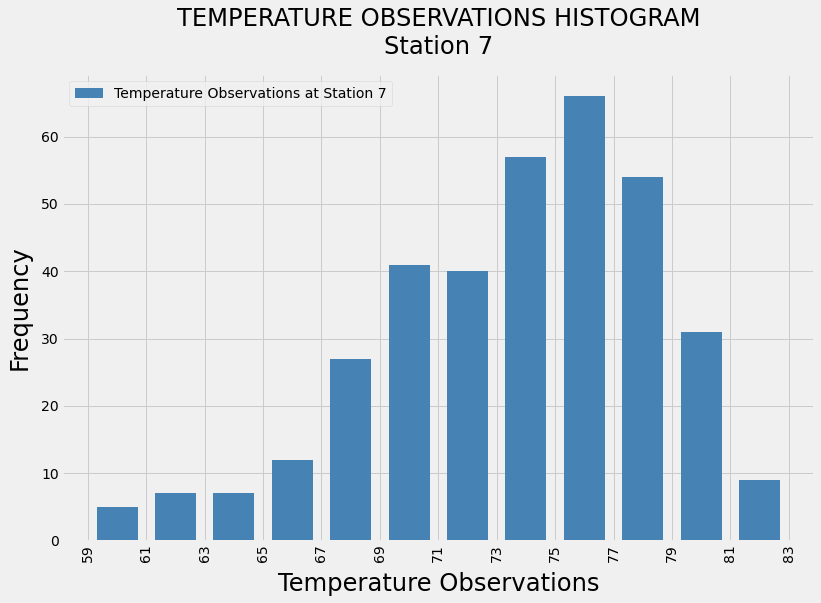

In [127]:
#Plot the temperature observations. 

temps = most_active_station_12months.iloc[:, 1]                       # Set up x axis

plt.figure(figsize=(12, 8))                                           # Set up plot figure size

n, bins, patches = plt.hist(temps, bins=12, histtype='bar',           # Plot histogram with 12 bins
                            align='mid', orientation='vertical', 
                            rwidth=.7,  color='steelblue', 
                            label=f"Temperature Observations at Station {most_active_station.id}")

plt.xticks(bins, rotation = 90)                                       # Set up x ticks

plt.xlabel('Temperature Observations',                                # Set up x axis label
           fontsize='xx-large', labelpad=10)
plt.ylabel('Frequency', fontsize='xx-large', labelpad=10)             # Set up y axis label

plt.title(f"TEMPERATURE OBSERVATIONS HISTOGRAM\nStation {most_active_station.id}", 
          fontsize='xx-large', loc='center', pad=20)                  # Set up title
          

plt.legend()                                                          # Add legend

plt.savefig("output_charts/temp_obs_histogram.png",                   # Export chart
            transparent=False)

plt.show()

# Close session

In [128]:
# Close Session
session.close()